In [1]:
if 'google.colab' in str(get_ipython()):
    import sys
    from google.colab import drive, output
    drive.mount('/content/drive')

    !pip install umap-learn
    !pip install umap-learn[plot]
    !pip install holoviews

    !pip install joypy

    output.clear()
    print("Running on colab")
    %load_ext autoreload
    %autoreload 1
    %cd '/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project'
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Dataloader')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Modules')
elif "zmqshell" in str(get_ipython()):
    print("Running on MIRP")
    root = "/home/mirp_ai/Documents/Daniel_Nieto/PhD/AutoEncoders_Ecoacoustics"
    root_path = "/media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido"
else:
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    print("Running local")

Running on MIRP


In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from six.moves import xrange
import datetime
import gc
import pandas as pd
import joypy

from scipy import signal
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler as Normalizer

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torchaudio.transforms as audio_transform


#from ResidualStack import ResidualStack
#from Residual import Residual

from Jaguas_DataLoader_rainless import SoundscapeData
from Models import ConvAE as AE
from AE_training_functions import TestModel, TrainModel
from AE_Clustering import AE_Clustering 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = xm.xla_device()

from datetime import timedelta
import wandb
from wandb import AlertLevel

!pip install umap-learn
!pip install umap-learn[plot]
import umap
import pacmap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import seaborn as sns
import pickle as pkl

import random
def _set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
_set_seed(1024)

gc.collect()

/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/dist

58391

In [3]:
# model_type = "AE"
# identifier = "batch_size_14_num_hiddens_64_"
# day = 4
# hour = 9
# date_format = f"day_{day}_hour_{hour}"

# y = torch.load(f"temporal_zamuro/Features/{folder}/AE_labels_{date_format}_No_rain_Audios_Jaguas.pth",  map_location=torch.device('cpu'))
# X = torch.load(f"{root}/Zamuro/temporal_zamuro/Features/AE_features_Zamuro.pth",  map_location=torch.device('cpu'))
df_ae = pd.read_csv(f"temporal_zamuro/Features/New_df_ae_unflat.csv")
audios = pd.read_csv(f"Complementary_Files/zamuro_audios_complete.csv", index_col=0)
recorders = pd.read_csv(f"Complementary_Files/zamuro_recorders.csv")



In [4]:
X = np.asarray(df_ae.loc[:,"0":"25919"])
y = list(df_ae.loc[:,"y"])
X = np.reshape(X, [X.shape[0], 5, X.shape[1]//5])
# X = np.reshape(X, [X.shape[0]*5, X.shape[2]])
X = np.mean(X, axis=1)
# y = np.repeat(y,5)
X.shape, len(y)
# np.save(f'temporal_zamuro/Features/X.npy', X)
# np.save(f'temporal_zamuro/Features/y.npy', y)

((53275, 5184), 53275)

In [5]:
from sklearn.preprocessing import LabelEncoder

y_hour = df_ae["hour"]
# y_hour = list(np.repeat(y_hour, 5))
y_cover = df_ae["cover"]
# y_cover = list(np.repeat(y_cover, 5))
y_site = df_ae["location"]
# y_site = list(np.repeat(y_site, 5))
y_stage = df_ae["hour_stage"]

encoder = LabelEncoder()
y_site = encoder.fit_transform(y_site)
y_cover = encoder.fit_transform(y_cover)
y_stage = encoder.fit_transform(y_stage)

In [6]:
tasa_submuestreo = 0.2

# Obtener el número de muestras a submuestrear
num_muestras_submuestreadas = int(len(X) * tasa_submuestreo)

# Generar índices aleatorios sin reemplazo
indices_submuestreo = np.random.choice(len(X), num_muestras_submuestreadas, replace=False)

X_norm = X[indices_submuestreo]
y_n = [y_cover[i] for i in indices_submuestreo]

In [7]:
def projector(data, y=None, method="PCA", n_components=2, random_state=0, **kwargs):
    
    if method == "PCA":
        X = PCA(n_components=n_components, random_state=0).fit_transform(data)
    elif method == "ICA":
        X = FastICA(n_components=n_components,
                    random_state=0).fit_transform(data)
    elif method == "tSNE":
        X = TSNE(n_components=n_components, learning_rate=kwargs["learning_rate"],
                 init=kwargs["init"], random_state=random_state,
                 n_jobs=kwargs["n_jobs"]).fit_transform(X_PCA)
        
    elif method == "UMAP":
        reducer = umap.UMAP(n_components=n_components, min_dist=kwargs["min_dist"],
                            metric=kwargs["metric"], n_neighbors=kwargs["n_neighbors"],
                            random_state=random_state, n_jobs=kwargs["n_jobs"])
        X = reducer.fit_transform(data)
    return X

In [ ]:
mapper = umap.UMAP(n_components=60, min_dist=0.01,
                            metric="euclidean", n_neighbors=75,
                            random_state=0, n_jobs=-1).fit(X)
X_UMAP = mapper.transform(X)

np.save(f'temporal_zamuro/Features/X_UMAP_60.npy', X_UMAP)



In [ ]:
import pacmap
embedded = pacmap.PaCMAP(n_components=60, n_neighbors=75, MN_ratio=0.01, FP_ratio=20) 
X_pacmap = embedded.fit_transform(X, init="pca")

np.save(f'temporal_zamuro/Features/X_pacmap_60.npy', X_pacmap)

### UMAP grid search
- https://pair-code.github.io/understanding-umap/
- Pre-selected params are: 0.1-60, 0.5-60, 0.5-180 and 1-60

In [ ]:
etiquetas = y_n
recuento_etiquetas = {}
for etiqueta in etiquetas:
    if etiqueta in recuento_etiquetas:
        recuento_etiquetas[etiqueta] += 1
    else:
        recuento_etiquetas[etiqueta] = 1

# Mostramos el recuento de cada etiqueta
for etiqueta, recuento in recuento_etiquetas.items():
    print(f"Etiqueta '{etiqueta}': {recuento} muestras")

In [ ]:
min_dist = 0.1
n_neighbor = 180
metric = "euclidean"
n_components = [2, 15, 30, 45, 60]

for i,component in enumerate(n_components):
    print(f"Running {component} components. Iteration {i+1} of {len(n_components)}")
    X_projected = projector(X_ae_norm, method="UMAP", 
                                 min_dist=min_dist,
                                 n_neighbors=n_neighbor,
                                 metric=metric, n_components=component, n_jobs=-1)

    np.save(f'temporal_zamuro/Features/X_ae_norm_UMAP_full_{component}D.npy', X_projected)

### Interactive 2D

In [ ]:
import plotly.graph_objs as go
import plotly.io as pio


# Crear la figura interactiva
fig = go.Figure()

# Agregar los puntos a la figura para cada par de componentes
for i in range(0, 30, 2):
    fig.add_trace(go.Scatter(
        x=X_projected_30d[:, i],
        y=X_projected_30d[:, i+1],
        mode='markers',
        marker=dict(
            size=1,
            color=y_n,
            colorscale='Viridis',
            opacity=1
        ),
        name=f'Componentes {i+1}-{i+2}'
    ))

# Establecer el diseño del gráfico
fig.update_layout(
    xaxis_title='UMAP Component 1',
    yaxis_title='UMAP Component 2',
    title='UMAP Projection in 2D with All Component Pairs (30 components)'
)

# Guardar la figura como un archivo HTML interactivo
# pio.write_html(fig, 'umap_projection_2d_all_pairs_30_components_interactive.html')

# Mostrar la figura interactiva
fig.show()

### Interactive 3D

In [ ]:
import plotly.graph_objs as go
import plotly.io as pio

min_dist = 0.5
n_neighbor = 180
metric = "euclidean"


# Crear la figura interactiva
fig = go.Figure()

# Agregar los puntos a la figura
for i in range(0, 30, 3):
    fig.add_trace(go.Scatter3d(
        x=X_projected_30d[:, i],
        y=X_projected_30d[:, i+1],
        z=X_projected_30d[:, i+2],
        mode='markers',
        marker=dict(
            size=1,
            color=y_n,
            colorscale='Viridis',
            opacity=0.5
        ),
        name=f'Componentes {i+1}-{i+3}'
    ))

# Establecer el diseño de la escena
fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    title='UMAP Projection in 3D with 30 components'
)

# Guardar la figura como un archivo HTML interactivo
pio.write_html(fig, 'umap_projection_3d_18_components_interactive5.html')

# Mostrar la figura interactiva
fig.show()


In [ ]:
import matplotlib.colors as mcolors
metrics = ["euclidean"]#, "minkowski", "correlation"]
min_dists = [0.01, 0.1, 0.5, 1]
n_neighbors = [15, 75, 180, 512]
covers = {0:"forest", 1:"pasture", 2:"savanna"}
stages = {0:"Day", 1:"Morning", 2:"Night"}

X_ae_norm = X

for metric in metrics:
    for min_dist in min_dists:
        for n_neighbor in n_neighbors:
            print(f"iterating with: \n metric: {metric} \n min_dist: {min_dist}, \n n_neighbors: {n_neighbor}")
            X_projected = projector(X_ae_norm, method="UMAP", 
                                    min_dist=min_dist,
                                    n_neighbors=n_neighbor,
                                    metric=metric, n_jobs=-1)
         
#             y_n = y_cover
#             labels = np.unique(y_n)
#             cmap = plt.get_cmap("inferno", len(labels))  # Cambia "viridis" por cualquier colormap que prefieras
#             norm = mcolors.BoundaryNorm(np.arange(len(labels) + 1) - 0.5, len(labels))
#             scatter = plt.scatter(X_projected[:, 0], X_projected[:, 1], alpha=0.1, s=0.1, c=y_n, cmap=cmap, norm=norm)
#             handles = [plt.Line2D([0], [0], marker='o', color=cmap(norm(i)), linestyle='', markersize=10) for i in range(len(labels))]
#             plt.legend(handles, [f'{covers[label]}' for label in labels], title='Classes')
# #             plt.savefig(f"temporal_zamuro/zamuro_projections/cover/UMAP_metric-{metric}_mindist-{min_dist}_nneighbors-{n_neighbor}_cover.pdf")
#             plt.show()
                 
#             y_n = y_hour
#             labels = np.unique(y_n)
#             cmap = plt.get_cmap("inferno", len(labels))  # Cambia "viridis" por cualquier colormap que prefieras
#             norm = mcolors.BoundaryNorm(np.arange(len(labels) + 1) - 0.5, len(labels))
#             scatter = plt.scatter(X_projected[:, 0], X_projected[:, 1], alpha=0.1, s=0.1, c=y_n, cmap=cmap, norm=norm)
#             handles = [plt.Line2D([0], [0], marker='o', color=cmap(norm(i)), linestyle='', markersize=5) for i in range(len(labels))]
#             plt.legend(handles, [f'{label}' for label in labels], title='Classes')
# #             plt.savefig(f"temporal_zamuro/zamuro_projections/hour/UMAP_metric-{metric}_mindist-{min_dist}_nneighbors-{n_neighbor}_hour.pdf")
#             plt.show()
        
#             y_n = y_site
#             labels = np.unique(y_n)
#             cmap = plt.get_cmap("inferno", len(labels))  # Cambia "viridis" por cualquier colormap que prefieras
#             norm = mcolors.BoundaryNorm(np.arange(len(labels) + 1) - 0.5, len(labels))
#             scatter = plt.scatter(X_projected[:, 0], X_projected[:, 1], alpha=0.1, s=0.1, c=y_n, cmap=cmap, norm=norm)
# #             plt.savefig(f"temporal_zamuro/zamuro_projections/site/UMAP_metric-{metric}_mindist-{min_dist}_nneighbors-{n_neighbor}_site.pdf")
#             plt.show()
    
            y_n = y_stage
            labels = np.unique(y_n)
            cmap = plt.get_cmap("inferno", len(labels))  # Cambia "viridis" por cualquier colormap que prefieras
            norm = mcolors.BoundaryNorm(np.arange(len(labels) + 1) - 0.5, len(labels))
            scatter = plt.scatter(X_projected[:, 0], X_projected[:, 1], alpha=0.1, s=0.1, c=y_n, cmap=cmap, norm=norm)
            handles = [plt.Line2D([0], [0], marker='o', color=cmap(norm(i)), linestyle='', markersize=5) for i in range(len(labels))]
            plt.legend(handles, [f'{stages[label]}' for label in labels], title='Classes')
            plt.savefig(f"temporal_zamuro/zamuro_projections/hour_stage/UMAP_metric-{metric}_mindist-{min_dist}_nneighbors-{n_neighbor}_hour.pdf")
            plt.show()
       

### Connectivity

In [ ]:
min_dist = [0.01]#, 0.001, 0.1, 0.5]
for dist in min_dist:
    mapper = umap.UMAP(n_components=2, min_dist=dist,
                                metric="euclidean", n_neighbors=75,
                                random_state=0, n_jobs=-1).fit(X)
    X_projected = mapper.transform(X)
    import umap.plot
    umap.plot.connectivity(mapper, show_points=True, edge_bundling='hammer')
    plt.savefig(f"temporal_zamuro/zamuro_projections/UMAP_Connectivity_{dist}.pdf")

In [ ]:
import umap.plot
umap.plot.connectivity(mapper, show_points=True, edge_bundling='hammer')

In [ ]:
plt.savefig(f"temporal_zamuro/zamuro_projections/UMAP_Connectivity_0.0001.pdf")


In [ ]:
import umap.plot
metrics = ["euclidean"]
min_dists = [0.001. 0.1]
n_neighbors = [75]

X_norm = [X[i] for i in indices_submuestreo]
for metric in metrics:
    for min_dist in min_dists:
        for n_neighbor in n_neighbors:
            print(f"iterating with: \n metric: {metric} \n min_dist: {min_dist}, \n n_neighbors: {n_neighbor}")
            mapper = umap.UMAP(n_components=2, min_dist=min_dist,
                            metric=metric, n_neighbors=n_neighbor,
                            random_state=0, n_jobs=-1).fit(X_norm)
            X_projected = mapper.transform(X_norm)
            y_n = [y_hora[i] for i in indices_submuestreo]
            labels = np.asarray(y_n)
            umap.plot.connectivity(mapper, show_points=True, labels=labels, theme= "viridis", edge_bundling='hammer')
            plt.savefig(f"temporal_zamuro/zamuro_projections/connectivity/hour/UMAP_connectivity_metric-{metric}_mindist-{min_dist}_nneighbors-{n_neighbor}_hammer.pdf")
            plt.show()            
            y_n = [y_site[i] for i in indices_submuestreo]
            labels = np.asarray(y_n)
            umap.plot.connectivity(mapper, show_points=True, labels=labels, theme= "viridis", edge_bundling='hammer')
            plt.savefig(f"temporal_zamuro/zamuro_projections/connectivity/site/UMAP_connectivity_metric-{metric}_mindist-{min_dist}_nneighbors-{n_neighbor}_hammer.pdf")
            plt.show()            
            y_n = [y_cover[i] for i in indices_submuestreo]
            labels = np.asarray(y_n)
            umap.plot.connectivity(mapper, show_points=True, labels=labels, theme= "viridis", edge_bundling='hammer')
            plt.savefig(f"temporal_zamuro/zamuro_projections/connectivity/cover/UMAP_connectivity_metric-{metric}_mindist-{min_dist}_nneighbors-{n_neighbor}_hammer.pdf")
            plt.show()

In [ ]:
import numpy as np
import umap.plot

for i in range(10):
    selected_labels = np.random.choice(np.unique(y_site), size=10, replace=False)

    selected_indices = np.where(np.isin(y_site, selected_labels))[0]

    sample_size = int(1 * len(selected_indices))

    subsample_indices = np.random.choice(selected_indices, size=sample_size, replace=False)

    # Submuestrear los datos
    X_norm = X[subsample_indices]
    y_site_subsampled = y_site[subsample_indices]

    mapper = umap.UMAP(n_components=2, min_dist=0.1,
                                metric="euclidean", n_neighbors=75,
                                random_state=0, n_jobs=-1).fit(X_norm)
    X_projected = mapper.transform(X_norm)
    y_n = y_site_subsampled
    labels = np.asarray(y_n)
    umap.plot.connectivity(mapper, show_points=True, labels=labels, theme= "viridis")
    plt.savefig(f"temporal_zamuro/zamuro_projections/site_subsampled/UMAP_connectivity_metric-{mapper.metric}_mindist-{mapper.min_dist}_nneighbors-{mapper.n_neighbors}_{i}.pdf")
    plt.show()
    umap.plot.points(mapper, labels=labels, theme= "viridis", alpha=0.2 )
    plt.savefig(f"temporal_zamuro/zamuro_projections/site_subsampled/UMAP_points_metric-{mapper.metric}_mindist-{mapper.min_dist}_nneighbors-{mapper.n_neighbors}_{i}.pdf")
    plt.show()


In [ ]:
# Submuestrear los datos
X_norm = X_ae_norm[subsample_indices]
y_site_subsampled = y_site[subsample_indices]

mapper = umap.UMAP(n_components=2, min_dist=0.1,
                            metric="euclidean", n_neighbors=180,
                            random_state=0, n_jobs=-1).fit(X_norm)
X_projected = mapper.transform(X_norm)
y_n = y_site_subsampled
labels = np.asarray(y_n)
umap.plot.connectivity(mapper, show_points=True, labels=labels, theme= "viridis")
plt.savefig(f"temporal_zamuro/zamuro_projections/connectivity/hour/UMAP_connectivity_metric-{metric}_mindist-{min_dist}_nneighbors-{n_neighbor}_hammer.pdf")
plt.show()    


In [ ]:
mapper.
#https://www.researchgate.net/publication/353863256_Clustering_with_UMAP_Why_and_How_Connectivity_Matters

In [ ]:
n_components = [2, 30, 60]
for i, comp in enumerate(n_components):
    mapper = umap.UMAP(n_components=comp, min_dist=1,
                                metric="euclidean", n_neighbors=60,
                                random_state=0, n_jobs=-1).fit(X_ae_norm)
    with open(f'temporal_zamuro/Features/X_ae_norm_UMAP_Embedded_full_{mapper.n_components}D.npy','wb') as f:
        pkl.dump(mapper, f)

In [ ]:
mapper = umap.UMAP(n_components=2, min_dist=1,
                            metric="euclidean", n_neighbors=60,
                            random_state=0, n_jobs=-1).fit(X_norm, y=y_n)
umap.plot.points(mapper, labels=labels, theme= "viridis", alpha=0.2 )
umap.plot.connectivity(mapper, show_points=True, labels=labels, theme= "viridis")


### PACMAP Parameter explorations

Running FP Ratio: 20, MN Ratio: 0.0001, n_neighbors: 75


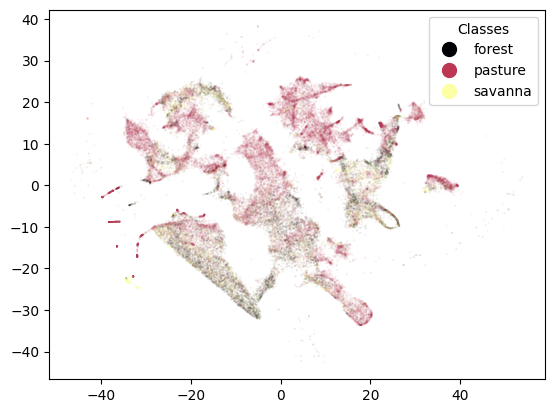

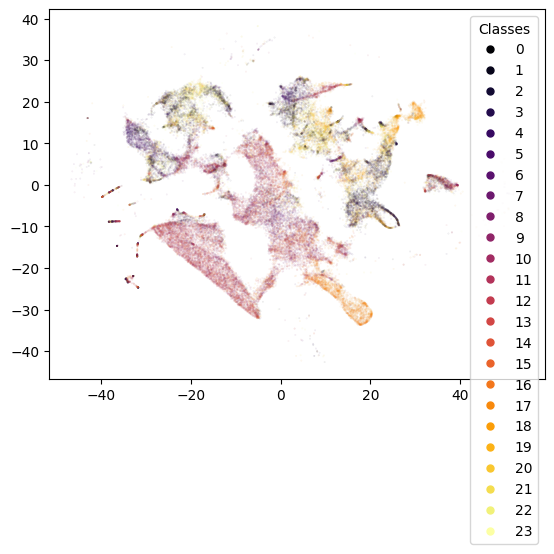

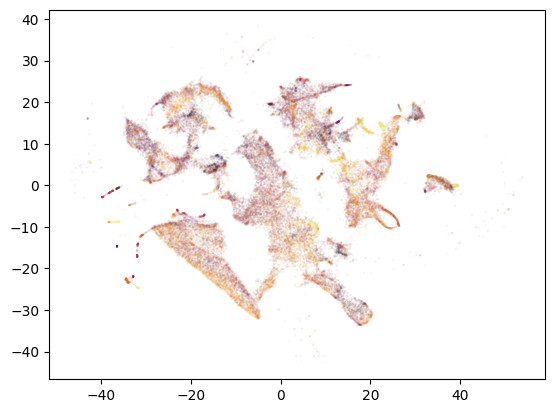

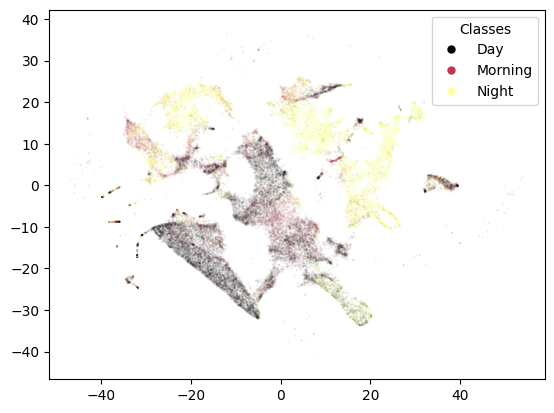

Time of execution: 1040.7705736160278
Running FP Ratio: 20, MN Ratio: 0.0001, n_neighbors: 180


In [ ]:
import pacmap
import time
import matplotlib.colors as mcolors

covers = {0:"forest", 1:"pasture", 2:"savanna"}
stages = {0:"Day", 1:"Morning", 2:"Night"}


FP_ratios = [20, 1, 10, 50]
MN_ratios = [0.0001, 0.01, 1, 0.5, 1]
n_neighbors = [75, 180]
# y_n = [y_cover[i] for i in indices_submuestreo]
X_norm = X
exec_times = []
for FP_ratio in FP_ratios:
    for MN_ratio in MN_ratios:
        for n_neighbor in n_neighbors:
            
            init_time = time.time()
            print(f"Running FP Ratio: {FP_ratio}, MN Ratio: {MN_ratio}, n_neighbors: {n_neighbor}")
            embedded = pacmap.PaCMAP(n_components=2, n_neighbors=n_neighbor, MN_ratio=MN_ratio, FP_ratio=FP_ratio) 
            X_pacmap = embedded.fit_transform(X_norm, init="pca")
            
            y_n = y_cover
            labels = np.unique(y_n)
            cmap = plt.get_cmap("inferno", len(labels))  # Cambia "viridis" por cualquier colormap que prefieras
            norm = mcolors.BoundaryNorm(np.arange(len(labels) + 1) - 0.5, len(labels))
            handles = [plt.Line2D([0], [0], marker='o', color=cmap(norm(i)), linestyle='', markersize=10) for i in range(len(labels))]
            plt.legend(handles, [f'{covers[label]}' for label in labels], title='Classes')
            plt.scatter(X_pacmap[:, 0], X_pacmap[:, 1], cmap=cmap, s=0.1, alpha=0.1, c=y_n)
#             plt.title(f"PACMAP_MNratio-{MN_ratio}_nneighbors-{n_neighbor}_FPratio_{FP_ratio}")
            plt.savefig(f"temporal_zamuro/zamuro_projections/PacMAP/cover/PACMAP_MNratio-{MN_ratio}_nneighbors-{n_neighbor}_FPratio_{FP_ratio}_cover.pdf")
            plt.show()
            
            
            y_n = y_hour
            labels = np.unique(y_n)
            cmap = plt.get_cmap("inferno", len(labels))  # Cambia "viridis" por cualquier colormap que prefieras
            norm = mcolors.BoundaryNorm(np.arange(len(labels) + 1) - 0.5, len(labels))
            scatter = plt.scatter(X_pacmap[:, 0], X_pacmap[:, 1], alpha=0.1, s=0.1, c=y_n, cmap=cmap, norm=norm)
            handles = [plt.Line2D([0], [0], marker='o', color=cmap(norm(i)), linestyle='', markersize=5) for i in range(len(labels))]
            plt.legend(handles, [f'{label}' for label in labels], title='Classes')
            plt.savefig(f"temporal_zamuro/zamuro_projections/PacMAP/hour/PACMAP_MNratio-{MN_ratio}_nneighbors-{n_neighbor}_FPratio_{FP_ratio}_hour.pdf")
            plt.show()

            y_n = y_site
            labels = np.unique(y_n)
            cmap = plt.get_cmap("inferno", len(labels))  # Cambia "viridis" por cualquier colormap que prefieras
            norm = mcolors.BoundaryNorm(np.arange(len(labels) + 1) - 0.5, len(labels))
            scatter = plt.scatter(X_pacmap[:, 0], X_pacmap[:, 1], alpha=0.1, s=0.1, c=y_n, cmap=cmap, norm=norm)
#             handles = [plt.Line2D([0], [0], marker='o', color=cmap(norm(i)), linestyle='', markersize=5) for i in range(len(labels))]
#             plt.legend(handles, [f'{label}' for label in labels], title='Classes')
            plt.savefig(f"temporal_zamuro/zamuro_projections/PacMAP/site/PACMAP_MNratio-{MN_ratio}_nneighbors-{n_neighbor}_FPratio_{FP_ratio}_site.pdf")
            plt.show()
        
            y_n = y_stage
            labels = np.unique(y_n)
            cmap = plt.get_cmap("inferno", len(labels))  # Cambia "viridis" por cualquier colormap que prefieras
            norm = mcolors.BoundaryNorm(np.arange(len(labels) + 1) - 0.5, len(labels))
            scatter = plt.scatter(X_pacmap[:, 0], X_pacmap[:, 1], alpha=0.1, s=0.1, c=y_n, cmap=cmap, norm=norm)
            handles = [plt.Line2D([0], [0], marker='o', color=cmap(norm(i)), linestyle='', markersize=5) for i in range(len(labels))]
            plt.legend(handles, [f'{stages[label]}' for label in labels], title='Classes')
            plt.savefig(f"temporal_zamuro/zamuro_projections/PacMAP/hour_stage/PACMAP_MNratio-{MN_ratio}_nneighbors-{n_neighbor}_FPratio_{FP_ratio}_stage.pdf")
            plt.show()
            
            plt.tight_layout()
            end_time = time.time()
            exec_time = end_time - init_time
            exec_times.append(exec_time)
            print(f"Time of execution: {exec_time}")

In [ ]:
embedded = pacmap.PaCMAP(n_components=2, n_neighbors=75, MN_ratio=0.01, FP_ratio=10) 
X_pacmap = embedded.fit_transform(X, init="pca")

In [ ]:
np.save(f'temporal_zamuro/zamuro_projections/PACMAP/exec_times.npy', X_projected)

### PACMAP featuring 

In [ ]:
import pacmap
import time
init_time = time.time()
embedded = pacmap.PaCMAP(n_components=2, n_neighbors=75, MN_ratio=0.01, FP_ratio=20) 
X_pacmap = embedded.fit_transform(X_norm, init="pca")
end_time = time.time()
exect_time = end_time - init_time
print(exect_time)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(X_pacmap[:, 0], X_pacmap[:, 1], cmap="viridis", s=0.01, alpha=0.5, c)

In [ ]:
embedded.pair_FP[0:60]

In [ ]:
np.save(f'temporal_zamuro/Features/X_ae_norm_PACMAP_Embedded_full_prueba_{embedded.n_components}D.npy', embedded)

## TriMAP Visualization

In [ ]:
import trimap

X_norm = X

inliers = [75, 180, 250, 512]
outliers = [15, 30, 75, 180]
randoms = [3, 30, 300]
for inlier in inliers:
    for outlier in outliers:
        for random in randoms:
            init_time = time.time()
            print(f"Running inlier: {inlier}, outlier: {outlier}, random: {random}")
            embedded = trimap.TRIMAP(n_dims=2, n_inliers=inlier, n_outliers=outlier, n_random=random) 
            X_trimap = embedded.fit_transform(X_norm)
            fig, ax = plt.subplots(1, 1, figsize=(6, 6))
            ax.scatter(X_trimap[:, 0], X_trimap[:, 1], cmap="viridis", s=0.01, alpha=0.5)
            plt.savefig(f"temporal_zamuro/zamuro_projections/Trimap/Trimap_inliers-{inlier}_outliers-{outlier}_random-{random}.pdf")
            plt.title(f"Trimap_inliers-{inlier}_outliers-{outlier}_random-{random}")
            plt.show()
            end_time = time.time()
            exec_time = end_time - init_time
            exec_times.append(exec_time)
            print(f"Time of execution: {exec_time}")

### PCA Elbow

In [ ]:
pca = PCA(n_components = 5184)
pca_fit = pca.fit(X)

In [ ]:
import seaborn as sns

# Set style and figure size
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Scree Plot
PC_values = np.arange(pca.n_components) + 1
plt.plot(PC_values[0:80], pca.explained_variance_ratio_[0:80].cumsum(),
         'o-',markersize=4, linewidth=1, color='maroon')

# Add text with explained variance ratio values on selected points
points_to_annotate = [2, 5, 10, 20, 30, 40, 50, 60, 80]  # Add values for the points you want to annotate
variance_ratio = pca.explained_variance_ratio_.cumsum()
for point in points_to_annotate:
    plt.text(point, variance_ratio[point-1]+0.02, f'{variance_ratio[point-1]*100:.2f}%', ha='center', va='bottom', fontsize=10)

# Titles and axis labels
plt.title('Scree Plot', fontsize=16)
plt.xlabel('Number of Principal Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)

# Save the figure as a PDF file
plt.savefig("temporal_zamuro/zamuro_projections/PCA/scree_plot_new.pdf",
             dpi=300)

# Show the plot
plt.show()

